In [1]:
import os
from settings import load_env
import openslide
from slide_utils import load_annotations, get_slide_offset
import json
from slide_utils import get_localized_polygon, Bounds, draw_polygons, get_union_bounds

os.environ['overrides'] = '__local.env'
load_env()

Overriding settings with values from local.env


Applying offset (43264, 103168)


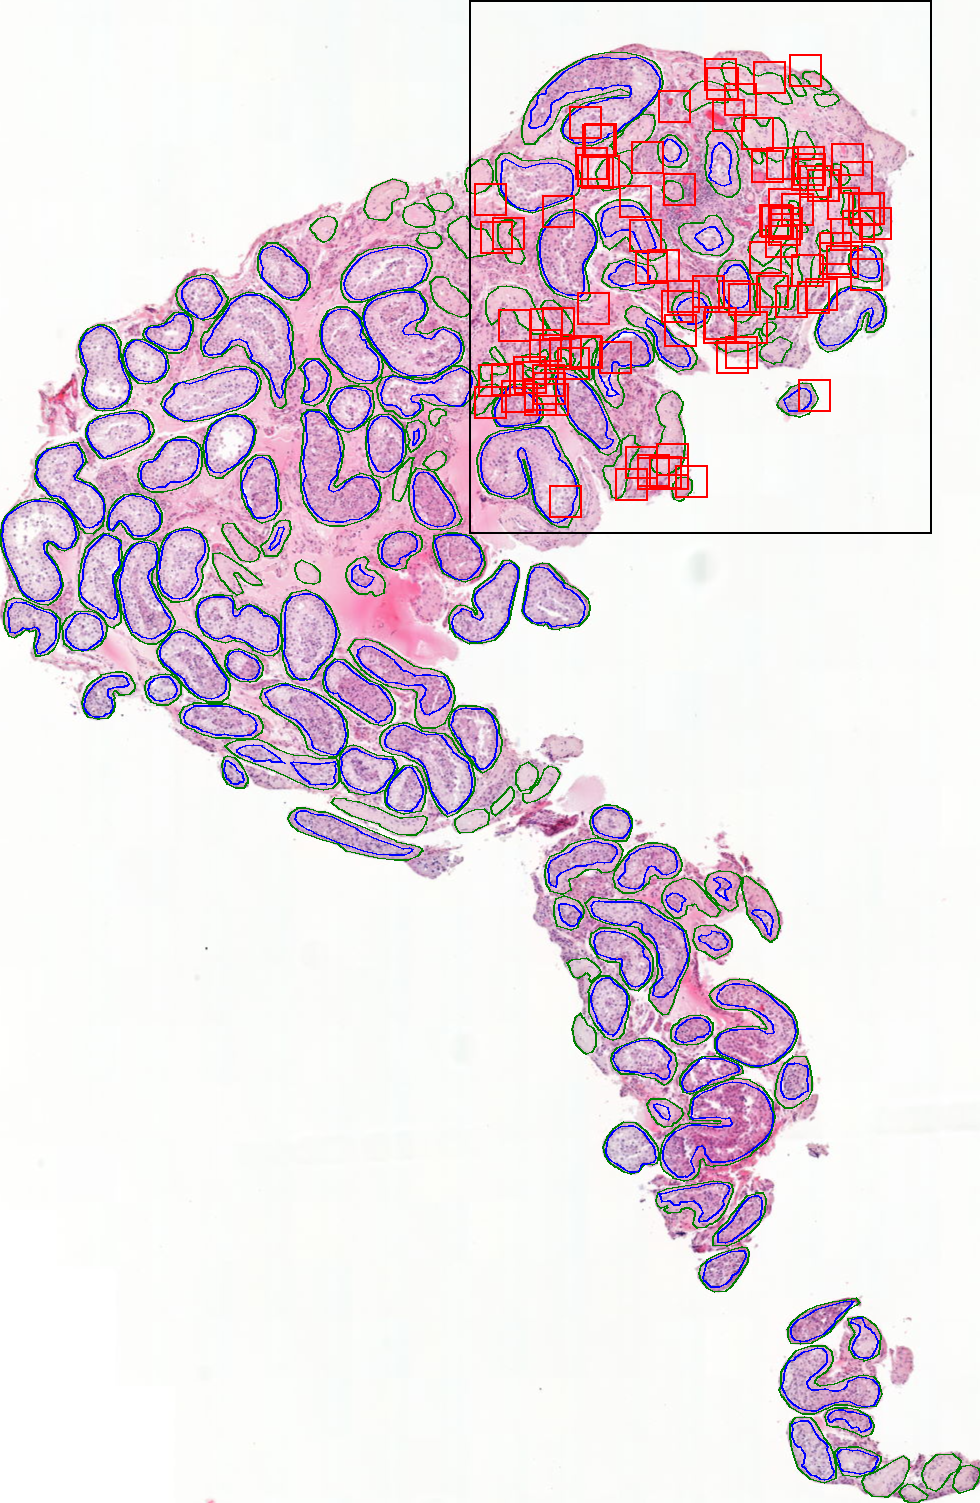

In [4]:
def get_dataset_illustration(slidename: str, runname: str, zoom: int):
    slide = openslide.open_slide(os.environ[f'slidefile_{slidename}'])
    annotations = load_annotations(os.environ[f'annotations_{slidename}'], get_slide_offset(slide))

    slides_path = f"{os.environ['slides']}/{slidename}/{runname}"

    with open(f"{slides_path}/train/meta.json", "r") as fp:
        train = json.load(fp)

    with open(f"{slides_path}/test/meta.json", "r") as fp:
        test = json.load(fp)

    train_bounds_list = [Bounds(**s['bounds']).to_polygon() for s in train['slices']]
    test_bounds_list = [Bounds(**s['bounds']).to_polygon() for s in test['slices']]

    sampled_region = get_union_bounds(train_bounds_list + test_bounds_list + annotations.outsides + list(annotations.regions.values())[0:1], zoom)

    img = slide.read_region(location=sampled_region.topleft, level=zoom, size=sampled_region.get_size())

    localized_outsides = [get_localized_polygon(sampled_region, poly) for poly in annotations.outsides]
    localized_insides = [get_localized_polygon(sampled_region, poly) for poly in annotations.insides]
    localized_regions = [get_localized_polygon(sampled_region, poly) for poly in list(annotations.regions.values())[0:1]]
    train_slices = [get_localized_polygon(sampled_region, poly) for poly in train_bounds_list]
    test_slices = [get_localized_polygon(sampled_region, poly) for poly in test_bounds_list]



    weights = {
        6: 1,
        5: 2,
        4: 4,
        3: 8,
        2: 16,
        1: 32,
        0: 64
    }
    line_weight=weights[zoom] if zoom < 7 else 1

    draw_polygons(img, localized_outsides, outline="green", width=line_weight)
    draw_polygons(img, localized_insides, outline="blue", width=line_weight)

    draw_polygons(img, localized_regions, outline="black", width=line_weight)

    draw_polygons(img, train_slices, outline="blue", width=line_weight)
    draw_polygons(img, test_slices, outline="red", width=line_weight)

    return img


img = get_dataset_illustration('gamma', 'level1_overlap10', 5)
img

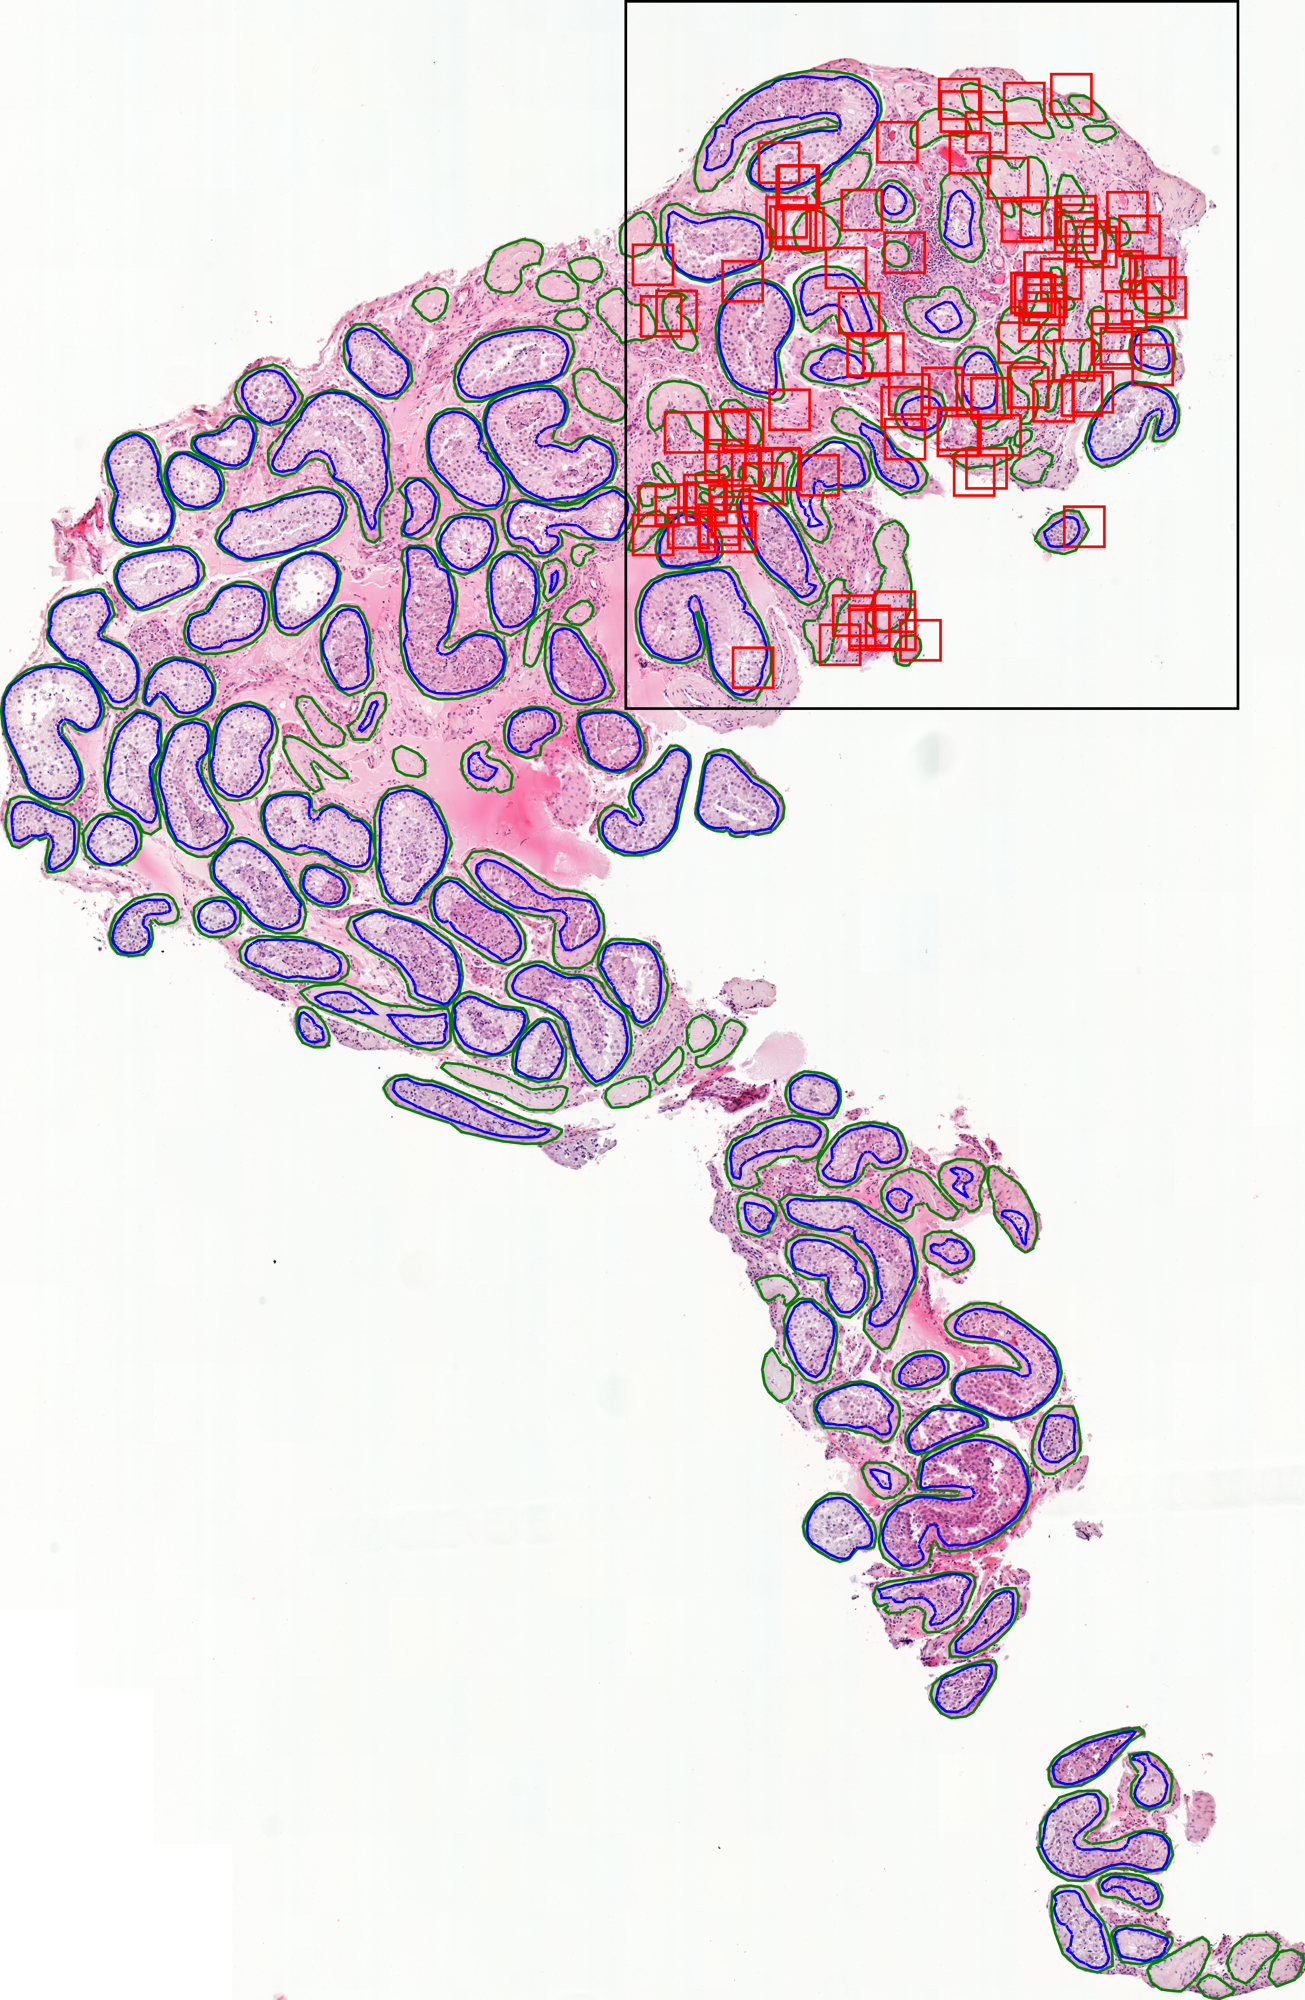

In [38]:
img.thumbnail((2000,2000))
img